## AS 7 - RNNs and LSTMs

Richard Yang

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import sys
import os
import json
import pandas
import numpy
import optparse
import tensorflow as tf
import keras            
from keras.utils import pad_sequences
from keras import preprocessing
from keras.callbacks import TensorBoard
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Embedding, Masking, SimpleRNN, Bidirectional
# from tensorflow.keras.layers import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Activation, SimpleRNN
from collections import OrderedDict


In [29]:
# Read the data
dataframe = pandas.read_csv("dev-access.csv", engine='python', quotechar='|', header=None)
dataset = dataframe.values
# Shape of the data
print(dataframe.shape)

(26773, 2)


In [30]:
X = dataset[:,0]
Y = dataset[:,1]    

In [31]:
# clean up the predictors.
for index, item in enumerate(X):
    # Quick hack to space out json elements
    reqJson = json.loads(item, object_pairs_hook=OrderedDict)
    del reqJson['timestamp']
    del reqJson['headers']
    del reqJson['source']
    del reqJson['route']
    del reqJson['responsePayload']
    X[index] = json.dumps(reqJson, separators=(',', ':'))

In [32]:
tokenizer = Tokenizer(filters='\t\n', char_level=True)
tokenizer.fit_on_texts(X)

# we will need this later
num_words = len(tokenizer.word_index)+1
X = tokenizer.texts_to_sequences(X)

In [33]:
max_log_length = 1024
X_processed = keras.utils.pad_sequences(X, maxlen=max_log_length)

In [34]:
# Create your train set to be 75% of the data and your test set to be 25%

from sklearn                                                                                                                                                                                                                                                                                                                                                                                                                                                                    .model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_processed, Y, test_size=0.25, random_state=42)

In [35]:
# convert the train and test data to float

X_train = X_train.astype(float)
X_test = X_test.astype(float)
Y_train = Y_train.astype(float)
Y_test = Y_test.astype(float)  

In [36]:
# check the shape of your train and test data

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(20079, 1024)
(6694, 1024)
(20079,)
(6694,)


## 2. Model 1 - RNN: 

The first model will be a pretty minimal RNN with only an embedding layer, simple RNN and Dense layer. The next model we will add a few more layers. 



In [37]:
# Create the RNN model

model = Sequential()



In [38]:
# From there, add an Embedding layer Params:- input_dim = num_words (the variable we created above)- output_dim = 32- input_length = max_log_length (we also created this above)- Keep all other variables as the defaults (shown below)

model.add(Embedding(num_words, 32, input_length=max_log_length))
model.add(SimpleRNN(units = 32,activation="relu"))
model.add(Dense(units=1, activation = "relu"))


In [39]:
#e) Compile model using the .compile() method:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [40]:
# f) Print out your model summary using the .summary                    () method:

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1024, 32)          2016      
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,129
Trainable params: 4,129
Non-trainable params: 0
_________________________________________________________________
None


In [41]:
# g) Use the .fit() method to fit the model on the train data. Use a validation split of 0.25, epochs=3 and batch size = 128.
# print the run time of the model

import time
start_time = time.time()
model.fit(X_train, Y_train, validation_split=0.25, epochs=3, batch_size=128)

print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/3
118/118 [==============================] - 28s 227ms/step - loss: 0.6540 - accuracy: 0.5931 - val_loss: 0.5419 - val_accuracy: 0.6510
Epoch 2/3
118/118 [==============================] - 26s 219ms/step - loss: 0.2670 - accuracy: 0.9084 - val_loss: 0.1220 - val_accuracy: 0.9560
Epoch 3/3
118/118 [==============================] - 27s 228ms/step - loss: 0.1117 - accuracy: 0.9641 - val_loss: 0.0910 - val_accuracy: 0.9809
--- 81.03095030784607 seconds ---


In [42]:
#h)  Use the .evaluate() method to get the loss value & the accuracy value on the test data. Use a batch size of 128 again.

loss, accuracy = model.evaluate(X_test, Y_test, batch_size=128)

print("Loss Value: ", loss)
print("Accuracy Value: ", accuracy)

53/53 [==============================] - 2s 44ms/step - loss: 0.1028 - accuracy: 0.9773
Loss Value:  0.1027505099773407
Accuracy Value:  0.977293074131012


## 3) Model 2 - LSTM + Dropout Layers:  

In [43]:
# a) Create a new model

model2 = Sequential()

model2.add(Embedding(num_words, 32, input_length=max_log_length))
model2.add(LSTM(units = 64, recurrent_dropout = 0.5))
model2.add(Dropout(0.5))
model2.add(Dense(units=1, activation = "relu"))

In [44]:
# b) Compile model using the .compile() method:

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [45]:
# c) Print the model summary
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1024, 32)          2016      
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 26,913
Trainable params: 26,913
Non-trainable params: 0
_________________________________________________________________


In [46]:
# Use the .fit() method to fit the model on the train data. Use a validation split of 0.25, epochs=3 and batch size = 128.

model2.fit(X_train, Y_train, validation_split=0.25, epochs=3, batch_size=128)

Epoch 1/3
118/118 [==============================] - 174s 1s/step - loss: 0.8760 - accuracy: 0.5580 - val_loss: 0.5654 - val_accuracy: 0.8371
Epoch 2/3
118/118 [==============================] - 169s 1s/step - loss: 0.6051 - accuracy: 0.7151 - val_loss: 0.5356 - val_accuracy: 0.6829
Epoch 3/3
118/118 [==============================] - 165s 1s/step - loss: 0.6022 - accuracy: 0.6344 - val_loss: 0.5566 - val_accuracy: 0.6478


In [47]:
#h)  Use the .evaluate() method to get the loss value & the accuracy value on the test data. Use a batch size of 128 again.

loss, accuracy = model2.evaluate(X_test, Y_test, batch_size=128)

print("Loss Value: ", loss)
print("Accuracy Value: ", accuracy)

53/53 [==============================] - 10s 189ms/step - loss: 0.5561 - accuracy: 0.6642
Loss Value:  0.5561341047286987
Accuracy Value:  0.664176881313324


## 4) Recurrent Neural Net Model 3: Build Your Own

In [48]:
# a) Create a new RNN model,  - Use 5 or more layers - Add a layer that was not utilized in Model 1 or Model 2 (Note: This could be a new Dense layer or an additional LSTM)

model3 = Sequential()

model3.add(Embedding(num_words, 32, input_length=max_log_length))
model3.add(Masking(mask_value=0.0))
model3.add(LSTM(units = 64, recurrent_dropout = 0.5))
model3.add(Dropout(0.25))
model3.add(Dense(units=32, activation = "relu"))
model3.add(Dense(units=16, activation = "relu"))
model3.add(Dense(units=1, activation = "relu"))


In [49]:
# b) Compile model using the .compile() method:
model3.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

# c) Print the model summary
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1024, 32)          2016      
                                                                 
 masking (Masking)           (None, 1024, 32)          0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                24832     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 1)                

In [50]:
# d) Use the .fit() method to fit the model on the train data. Use a validation split of 0.25, epochs=3 and batch size = 128.
model3.fit(X_train, Y_train, validation_split=0.25, epochs=3, batch_size=128)

Epoch 1/3
118/118 [==============================] - 201s 2s/step - loss: 7.5493 - accuracy: 0.5027 - val_loss: 7.5669 - val_accuracy: 0.5038
Epoch 2/3
118/118 [==============================] - 196s 2s/step - loss: 7.5937 - accuracy: 0.5020 - val_loss: 7.5669 - val_accuracy: 0.5038
Epoch 3/3
118/118 [==============================] - 194s 2s/step - loss: 7.5937 - accuracy: 0.5020 - val_loss: 7.5669 - val_accuracy: 0.5038


In [51]:
#h)  Use the .evaluate() method to get the loss value & the accuracy value on the test data. Use a batch size of 128 again.

loss, accuracy = model3.evaluate(X_test, Y_test, batch_size=128)

print("Loss Value: ", loss)
print("Accuracy Value: ", accuracy)

53/53 [==============================] - 12s 225ms/step - loss: 7.7978 - accuracy: 0.4886
Loss Value:  7.797750949859619
Accuracy Value:  0.488646537065506


## Conceptual Questions

5) Explain the difference between the relu activation function and the sigmoid activation function.

- The difference between the relu activation function and the sigmoid activation function is that the relu activation function is a linear function that outputs the input directly if it is positive, otherwise, it outputs zero. The sigmoid activation function is a non-linear function that outputs a value between 0 and 1.

- ReLU is commonly used in hidden layers of neural networks to introduce non-linearity and address the vanishing gradient problem, while sigmoid is often used in the output layer for binary classification tasks or when the output needs to be interpreted as a probability.


6) Describe what one epoch actually is (epoch was a parameter used in the .fit() method).

- One epoch is when an entire dataset is passed forward and backward through the neural network only once. The number of epochs is a hyperparameter that defines the number times that the learning algorithm will work through the entire training dataset. One epoch means that each sample in the training dataset has had an opportunity to update the internal model parameters. An epoch is comprised of one or more batches. For example, as above, an epoch that has one batch is called the batch gradient descent learning algorithm. An epoch that has a batch size equal to the entire dataset is called the mini-batch gradient descent learning algorithm. Finally, stochastic gradient descent learning refers to an epoch that only has a batch size of one.

7) Explain how dropout works (you can look at the keras code and/or documentation) for (a) training, and (b) test data sets.

- Dropout is a regularization technique for reducing overfitting in neural networks by preventing complex co-adaptations on training data. It is a very efficient way of performing model averaging with neural networks. 

- The term "dropout" refers to dropping out units (both hidden and visible) in a neural network. Dropout is a technique where randomly selected neurons are ignored during training. They are "dropped-out" randomly. This means that their contribution to the activation of downstream neurons is temporally removed on the forward pass and any weight updates are not applied to the neuron on the backward pass. Dropout is a regularization method that approximates training a large number of neural networks with different architectures in parallel. 

- During training, some number of layer outputs are randomly ignored or "dropped out." This has the effect of making the layer look-like and be treated-like a layer with a different number of nodes and connectivity to the prior layer. In effect, each update to a layer during training is performed with a different "view" of the configured layer. Dropout has the effect of making the training process noisy, forcing nodes within a layer to probabilistically take on more or less responsibility for the inputs.


8) Explain why problems such as this homework assignment are better modeled with RNNs than CNNs. What type of problem will CNNs outperform RNNs on?

- RNNs are better modeled with RNNs than CNNs because RNNs are designed to recognize patterns in **sequences** of data, such as text, genomes, handwriting, the spoken word, or numerical times series data emanating from sensors, stock markets and government agencies. CNNs are better modeled with RNNs than CNNs because 

- CNNs are designed to recognize patterns in images, such as handwritten digits, or to recognize objects in images, such as cats, dogs, cars, or airplanes. CNNs are also used for object recognition in images and video, image classification, and image segmentation. CNNs are also used for natural language processing, recommender systems, and anomaly detection.

9) Explain what RNN problem is solved using LSTM and briefly describe how.

- The long dependency problem can be solved using LSTM. 

- LSTM is a special kind of RNN that is capable of learning long-term dependencies. LSTM is explicitly designed to avoid the long-term dependency problem. All recurrent neural networks have the form of a chain of repeating modules of neural network. In standard RNNs, this repeating module will have a very simple structure, such as a single tanh layer. LSTMs also have this chain like structure, but the repeating module has a different structure. Instead of having a single neural network layer, there are four, interacting in a very special way. 

- LSTM addresses the limitations of traditional RNNs by introducing memory cells and gating mechanisms. These components enable the LSTM to selectively retain and update information over time, allowing it to capture long-term dependencies in sequential data. By incorporating input gates, forget gates, and output gates, LSTMs can control the flow of information, enhancing their ability to remember and utilize relevant information while discarding unnecessary details.

## PART B: Time Series with LSTMs

In [20]:
import pandas
import numpy as np
from matplotlib import pyplot as plt

# Import, clean and plot the input data
df = pandas.read_csv("DAYTON_hourly.csv")
df = df.dropna()
df.Datetime = pandas.to_datetime(df.Datetime)
# sort by date
df.sort_values(by='Datetime', inplace=True)
df


,Datetime,DAYTON_MW
2183,2004-10-01 01:00:00,1621.0
2184,2004-10-01 02:00:00,1536.0
2185,2004-10-01 03:00:00,1500.0
2186,2004-10-01 04:00:00,1434.0
2187,2004-10-01 05:00:00,1489.0
...,...,...
116159,2018-08-02 20:00:00,2554.0
116160,2018-08-02 21:00:00,2481.0
116161,2018-08-02 22:00:00,2405.0
116162,2018-08-02 23:00:00,2250.0


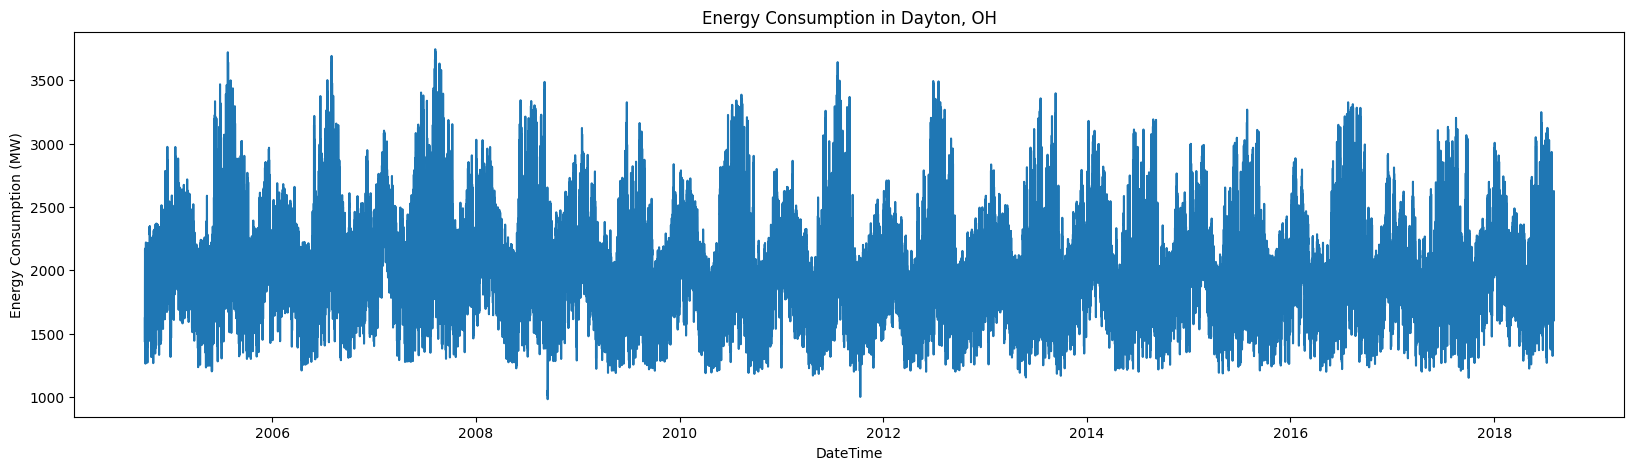

In [17]:
# set the index to the datetime variable
df.set_index('Datetime', inplace=True)
# plot time series data (use figsize (20,5))
plt.figure(figsize=(20,5))
plt.plot(df['DAYTON_MW'])
plt.title('Energy Consumption in Dayton, OH')
plt.xlabel('DateTime')
plt.ylabel('Energy Consumption (MW)')
plt.show()

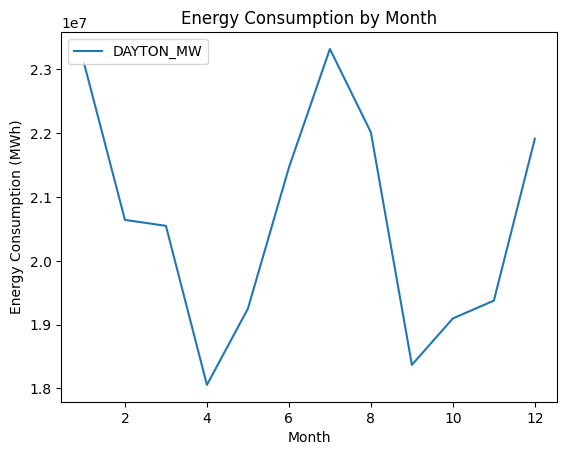

In [25]:
# Plot the data, group by month and sum the values
# Create a new column for year
df = pandas.read_csv("DAYTON_hourly.csv")
df = df.dropna()
df['month'] = pandas.DatetimeIndex(df['Datetime']).month

# Group by year and sum the values
df_grouped = df.groupby('month').sum()

# Plot the data
df_grouped.plot()
# Add legend
plt.legend(loc='upper left')
# Add title and x, y axes labels
plt.title('Energy Consumption by Month')
plt.xlabel('Month')
plt.ylabel('Energy Consumption (MWh)')
# Show plot
plt.show()





In [53]:
# Train test split (use provided helper function helper.py Download helper.py, as we can’t use sklearn’s for time series data)
# Lag = 3 hours
# Split the data into train and test sets
import pandas as pd
import numpy as np
from typing import Tuple


def create_data_for_NN(
    data: pd.DataFrame, Y_var: str, lag: int, test_ratio: float
) -> Tuple[np.array, np.array, np.array, np.array]:
    """Function to return lagged time series data after train-test split

    Args:
        data (pd.DataFrame): Raw time series data frame
        Y_var (str): String with the name of y variable
        lag (int): number of lagged records to consider
        test_ratio (float): ratio of data to consider for test set

    Returns:
        Tuple[np.array, np.array, np.array, np.array]: Lagged and split numpy arrays
    """
    y = data[Y_var].tolist()

    X, Y = [], []

    if len(y) - lag <= 0:
        X.append(y)
    else:
        for i in range(len(y) - lag):
            Y.append(y[i + lag])
            X.append(y[i : (i + lag)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an LSTM input shape
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    # Creating training and test sets
    X_train = X
    X_test = []

    Y_train = Y
    Y_test = []

    if test_ratio > 0:
        index = round(len(X) * test_ratio)
        X_train = X[: (len(X) - index)]
        X_test = X[-index:]

        Y_train = Y[: (len(X) - index)]
        Y_test = Y[-index:]

    return X_train, X_test, Y_train, Y_test




#### Fit a single layer LSTM with lag = 3 hours

In [63]:
lag = 3
test_ratio = 0.15

data = pd.read_csv("DAYTON_hourly.csv")
data.Datetime = pd.to_datetime(data.Datetime)
data.sort_values(by="Datetime", inplace=True)

X_train, X_test, Y_train, Y_test = create_data_for_NN(
    data, data.columns[-1], lag, test_ratio
)

In [64]:
# Create a new model
model_B_lag3 = Sequential()
# Add an LSTM layer with 64 internal units
model_B_lag3.add(LSTM(units = 64, recurrent_dropout = 0.5))
# Add a dense layer with 1 units
model_B_lag3.add(Dense(units=1, activation = "relu"))
# compile the model
model_B_lag3.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
# Fit the model
model_B_lag3.fit(X_train, Y_train, validation_split=0.25, epochs=3, batch_size=128)

Epoch 1/3
604/604 [==============================] - 6s 5ms/step - loss: 4367332.5000 - accuracy: 0.0000e+00 - val_loss: 4065780.5000 - val_accuracy: 0.0000e+00
Epoch 2/3
604/604 [==============================] - 3s 4ms/step - loss: 4332633.0000 - accuracy: 0.0000e+00 - val_loss: 4032421.2500 - val_accuracy: 0.0000e+00
Epoch 3/3
604/604 [==============================] - 3s 5ms/step - loss: 4298276.0000 - accuracy: 0.0000e+00 - val_loss: 3998875.2500 - val_accuracy: 0.0000e+00


In [65]:
# calculate the root mean squared error
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse_lag3 = sqrt(mean_squared_error(Y_test, model_B_lag3.predict(X_test)))
rmse_lag3

569/569 [==============================] - 1s 2ms/step


2039.5223139044397

569/569 [==============================] - 1s 1ms/step


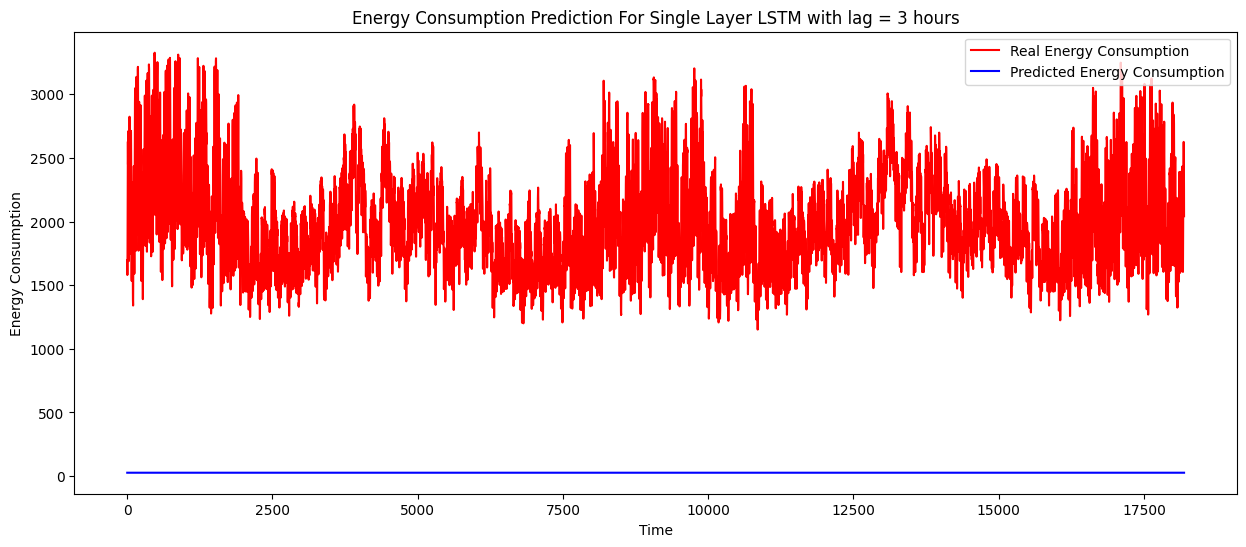

In [66]:
# plot the results
plt.figure(figsize=(15,6))
plt.plot(Y_test, color = 'red', label = 'Real Energy Consumption')
plt.plot(model_B_lag3.predict(X_test), color = 'blue', label = 'Predicted Energy Consumption')
plt.title('Energy Consumption Prediction For Single Layer LSTM with lag = 3 hours')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()


#### Fit a Single Layer LSTM with lag = 24 hours

In [54]:
lag = 24
test_ratio = 0.15


X_train, X_test, Y_train, Y_test = create_data_for_NN(
    data, data.columns[-1], lag, test_ratio
)

In [55]:
# Create a new model
model_B_lag24 = Sequential()
# Add an LSTM layer with 64 internal units
model_B_lag24.add(LSTM(units = 64, recurrent_dropout = 0.5))
# Add a dense layer with 1 units
model_B_lag24.add(Dense(units=1, activation = "relu"))
# compile the model
model_B_lag24.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
# Fit the model
model_B_lag24.fit(X_train, Y_train, validation_split=0.25, epochs=3, batch_size=128)

Epoch 1/3
604/604 [==============================] - 17s 24ms/step - loss: 4386511.5000 - accuracy: 0.0000e+00 - val_loss: 4101918.7500 - val_accuracy: 0.0000e+00
Epoch 2/3
604/604 [==============================] - 13s 22ms/step - loss: 4386508.5000 - accuracy: 0.0000e+00 - val_loss: 4101918.7500 - val_accuracy: 0.0000e+00
Epoch 3/3
604/604 [==============================] - 14s 23ms/step - loss: 4386508.0000 - accuracy: 0.0000e+00 - val_loss: 4101918.7500 - val_accuracy: 0.0000e+00


In [56]:
# calculate the root mean squared error
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse_lag24_single = sqrt(mean_squared_error(Y_test, model_B_lag24.predict(X_test)))
rmse_lag24_single

569/569 [==============================] - 2s 3ms/step


2065.0413220720225

569/569 [==============================] - 2s 3ms/step


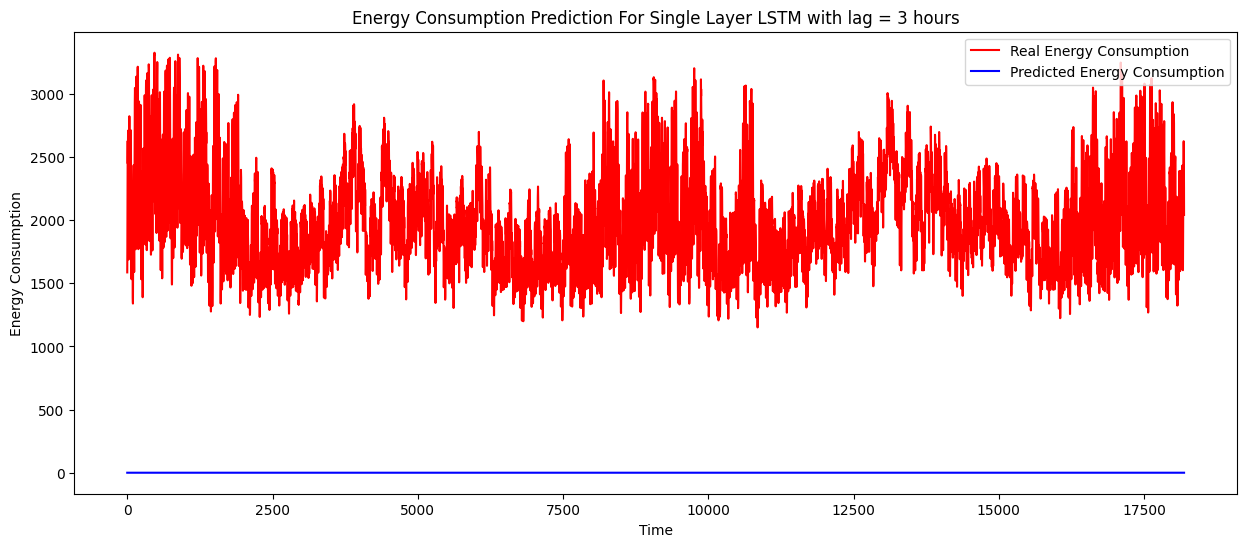

In [57]:
# plot the results
plt.figure(figsize=(15,6))
plt.plot(Y_test, color = 'red', label = 'Real Energy Consumption')
plt.plot(model_B_lag24.predict(X_test), color = 'blue', label = 'Predicted Energy Consumption')
plt.title('Energy Consumption Prediction For Single Layer LSTM with lag = 3 hours')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()


#### Fit a bidirectional LSTM with lag = 24 hours

In [58]:
lag = 24
test_ratio = 0.15

X_train, X_test, Y_train, Y_test = create_data_for_NN(
    data, data.columns[-1], lag, test_ratio
)

In [59]:
# Create a new model
model_B_lag24 = Sequential()
# Fit a bidirectional LSTM with lag = 24 hours
model_B_lag24.add(Bidirectional(LSTM(units = 64, recurrent_dropout = 0.5), input_shape=(X_train.shape[1], X_train.shape[2])))
# Add a dense layer with 1 units
model_B_lag24.add(Dense(units=1, activation = "relu"))
# compile the model
model_B_lag24.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
# Fit the model
model_B_lag24.fit(X_train, Y_train, validation_split=0.25, epochs=3, batch_size=128)

Epoch 1/3
604/604 [==============================] - 26s 36ms/step - loss: 4342845.0000 - accuracy: 0.0000e+00 - val_loss: 4021267.7500 - val_accuracy: 0.0000e+00
Epoch 2/3
604/604 [==============================] - 22s 36ms/step - loss: 4261585.5000 - accuracy: 0.0000e+00 - val_loss: 3940881.2500 - val_accuracy: 0.0000e+00
Epoch 3/3
604/604 [==============================] - 20s 34ms/step - loss: 4180444.7500 - accuracy: 0.0000e+00 - val_loss: 3864106.0000 - val_accuracy: 0.0000e+00


In [60]:
# calculate the root mean squared error
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse_lag24_bi = sqrt(mean_squared_error(Y_test, model_B_lag24.predict(X_test)))
rmse_lag24_bi

569/569 [==============================] - 3s 4ms/step


2005.5014030949794

569/569 [==============================] - 2s 4ms/step


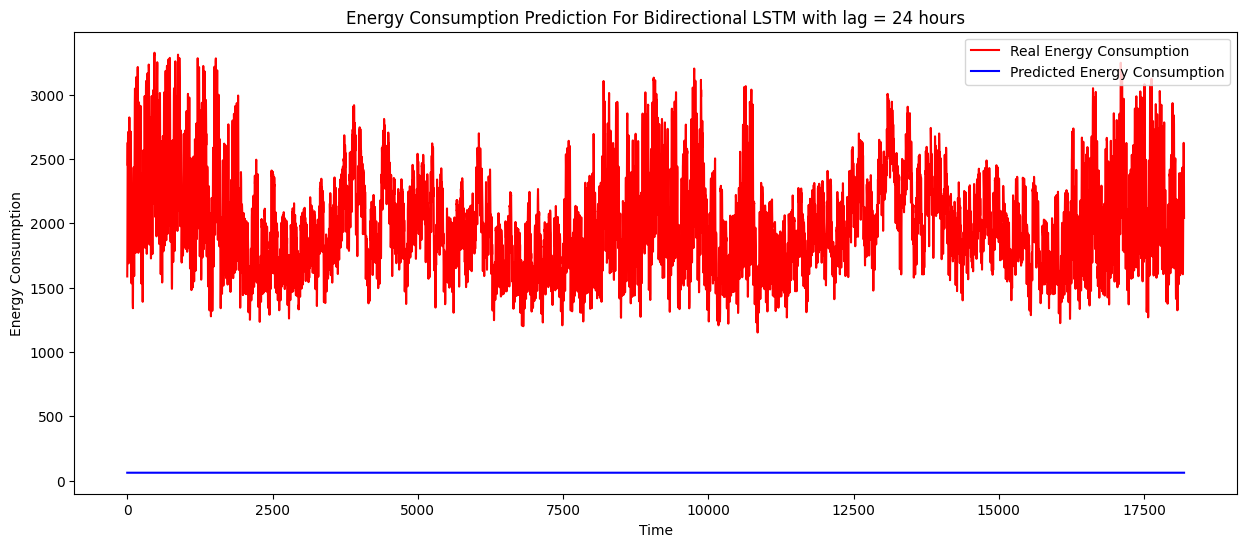

In [61]:
# plot the results
plt.figure(figsize=(15,6))
plt.plot(Y_test, color = 'red', label = 'Real Energy Consumption')
plt.plot(model_B_lag24.predict(X_test), color = 'blue', label = 'Predicted Energy Consumption')
plt.title('Energy Consumption Prediction For Bidirectional LSTM with lag = 24 hours')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()


In [67]:
# print rmse for all models
print("rmse for single layer LSTM with lag = 3 hours: ", rmse_lag3)
print("rmse for single layer LSTM with lag = 24 hours: ", rmse_lag24_single)
print("rmse for bidirectional LSTM with lag = 24 hours: ", rmse_lag24_bi)

rmse for single layer LSTM with lag = 3 hours:  2039.5223139044397
rmse for single layer LSTM with lag = 24 hours:  2065.0413220720225
rmse for bidirectional LSTM with lag = 24 hours:  2005.5014030949794


In [68]:
import datetime
import pytz

time = datetime.datetime.now(pytz.timezone('US/Central')).strftime("%a, %d %B %Y %H:%M:%S")
sign = 'Richard Yang'

print(f'Created at: {time} by {sign}')

Created at: Mon, 08 May 2023 00:42:09 by Richard Yang
